# Выбор стратегии работы с клиентами для сети фитнес-центров

## Цель исследования

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. 

Необходимо подготовить следующие аналитические данные:
1. типичные портреты клиентов: наиболее яркие группы и их основные характеристики;
2. основные признаки, наиболее сильно влияющие на отток;
3. рекомендации по повышению качества работы с клиентами:
 - целевые группы клиентов;
 - меры по снижению оттока;
 - особенности взаимодействия с клиентами.

## Загрузка данных

### Импорт библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from scipy.cluster.hierarchy import dendrogram, linkage
import itertools

### Загрузка данных из файла

In [2]:
gym = pd.read_csv('/datasets/gym_churn.csv')
gym.shape

(4000, 14)

In [3]:
gym.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


### Вывод

Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Полученный датасет модержит  4000 строк и 14 столбцов.

Набор данных включает следующие поля:


Данные клиента за предыдущий до проверки факта оттока месяц:
- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).


Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- 'Churn' — факт оттока в текущем месяце.

## Предобработка данных

### Типы данных и пропуски

In [4]:
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Пропусков не обнаружено, все данные имеют числовой тип, это нас устраивает.

### Переименование столбцов

Для удобства приведем названия столбцов к нижнему регистру:

In [5]:
gym.columns = gym.columns.str.lower()

In [6]:
gym.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

### Проверка наличия дубликатов

In [7]:
gym.duplicated().sum()

0

Дубликатов не обнаружено.

## Исследовательский анализ данных

### Описание данных

Посмотрим на основные числовые характеристики параметров и целевой переменной:

In [8]:
gym.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


Признаки gender, near_location, partner, promo_friends, phone, group_visits, а также целевая переменная churn являются бинарными, т.е. принимают значения 0 ("нет") или 1("да").


- Распределение по полу у нас довольно равномерное - 49/51. Кто из них мужчины, а кто женщины, мы не знаем, но раз их почти поровну, то это не критично.
- 85% клиентов сети живут или работают рядом с фитнес-клубом, что логично, т.к. минимизирует затраты времени на дорогу.
- Примерно половина клиентов (49%) - это сотрудники компаний-партнеров клуба.
- 31% клиентов использовали при оплате первого абонемента промокод друга. Довольно высокий показатель, акция "приведи друга" пользуется популярностью. Но радует и то, что подавляющее большинство клиентов (69%) приходят и без акции.
- 90% посетителей оставили свой контактный номер телефона. В наше время это обычная и удобная практика.
- 41% занимающихся посещают групповые занятия. Соответственно бОльшая часть (59%) предпочитает индивидуальные занятия либо ходят самостоятельно заниматься в тренажерный зал.
- Отток в текущем месяце составил 27%. Много это или мало - мы не можем оценить, для оценки нужно либо сравнение с конкурентами, либо с другими периодами.

Характеристики небинарных признаков:
- Срок абонемента бывает 1, 6 или 12 месяцев, медиана - 1 месяц, среднее - 4,7 месяцев, т.е. данные имеют пик в районе 1 месяца и хвост справа. Длительные абонементы на год менее популярны, чем краткосрочные. Это и понятно, годовой абонемент требует единовременного вложения относительно крупной суммы денег и предсказать свою жизнь на год вперед способны не многие.
- Возраст аудитории у нас от 18 до 41 года, средний и медианный возраст совпадают и составляют 29 лет.
- Отдельный клиент приобретает сопутствующие товары и услуги на сумму от 0,2 до 553 у.е., в среднем - 145 у.е., медиана- 136 у.е. Т.е. пик распределения смещен влево, посетители в большинстве своем склонны экономить на дополнительных "плюшках".
- Количество месяцев до конца абонемента - данный показатель по своим характеристикам сильно похож на срок абонемента.
- Время с момента первого обращения - срок жизни клиента в месяцах - от 0 до 31 месяца (2 года и 7 месяцев). Медиана - 3 месяца, средний показатель - 3,7 месяцев. 75% аудитории посещает фитнес-клубы нашей сети 5 или менее месяцев. Пик смещен влево,  хвост справа. "Долгожители" в меньшинстве.
- Средняя посещаемость в неделю за весь период - от 0 до 6 раз. В среднем около 2х раз. Нормальная ситуация для большинства людей со средней физической подготовкой. Пик смещен влево, хвост справа. 6 раз в неделю - это уже для фанатов.
- Средняя посещаемость в неделю за последний месяц - показатель по своим характеристикам аналогичен предыдущему.

### Среднее значение признаков для оттока и для оставшихся

Посмотрим, различаются ли средние значения признаков для тех, кто ушел, и тех, кто остался:

In [9]:
groups = gym.groupby('churn').agg('mean')
groups.T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


 Половой состав и наличие контактного телефона одинаковы у обеих групп. Значит, эти признаки не влияют на отток.
 Остальные показатели у оставшихся в среднем выше, чем у попавших в отток. 
 

### Распределение признаков для оттока и для оставшихся

Для наглядности визуализируем распределения признаков для обеих групп:

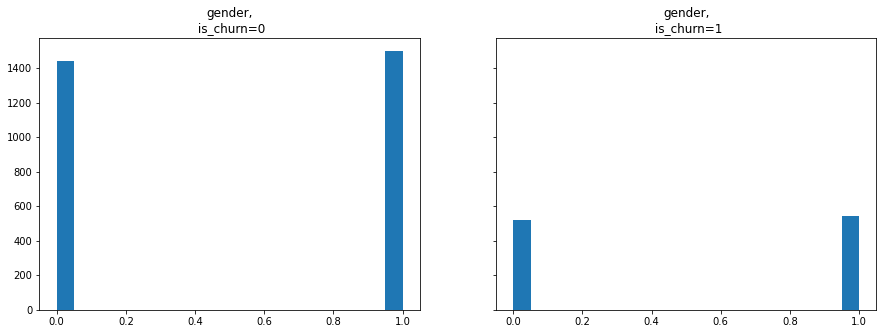

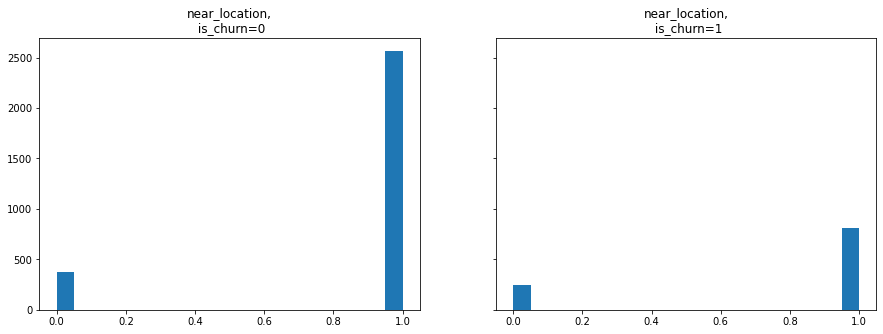

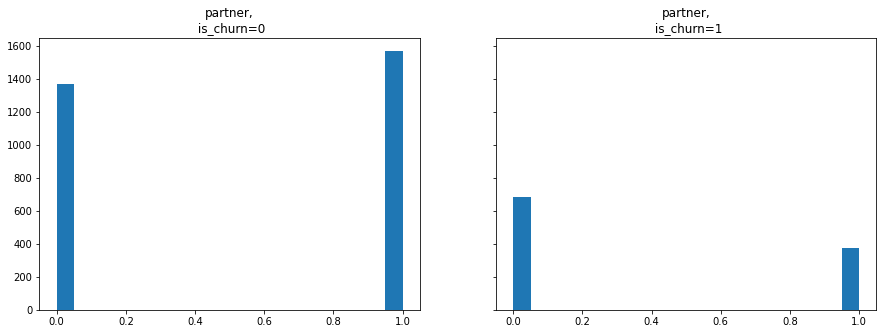

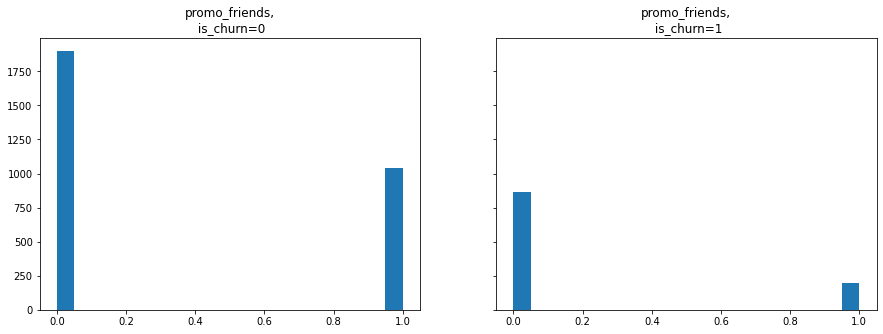

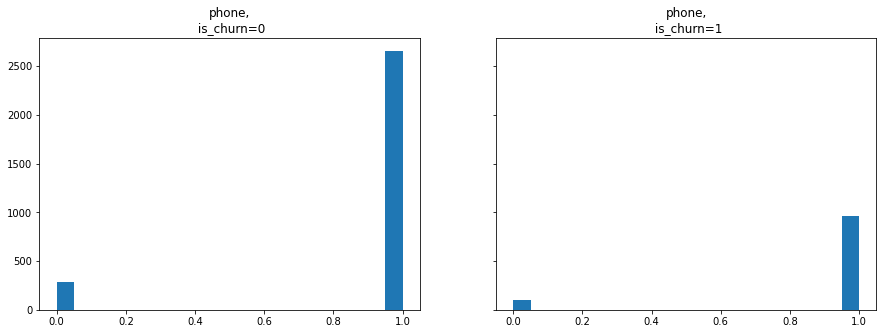

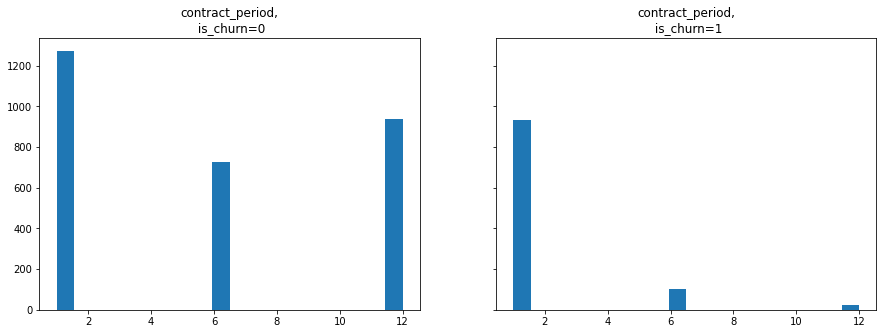

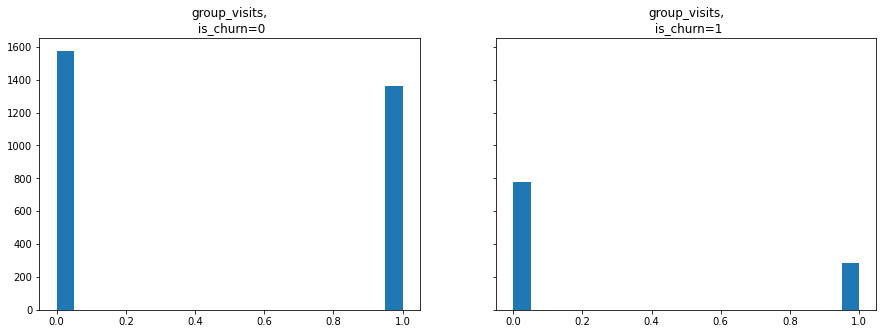

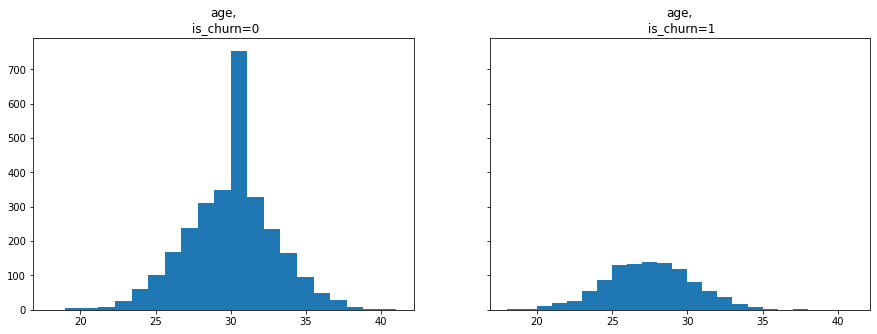

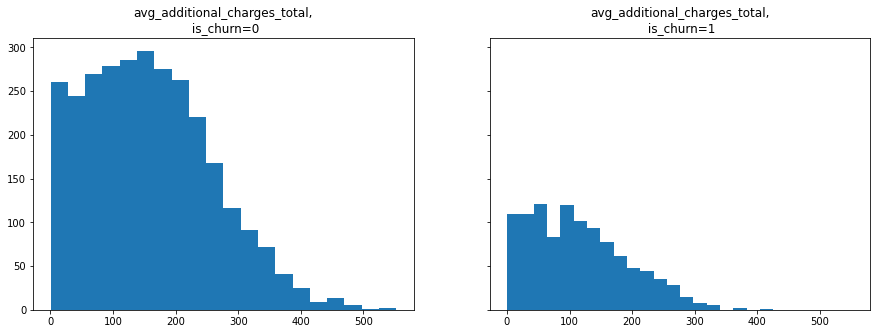

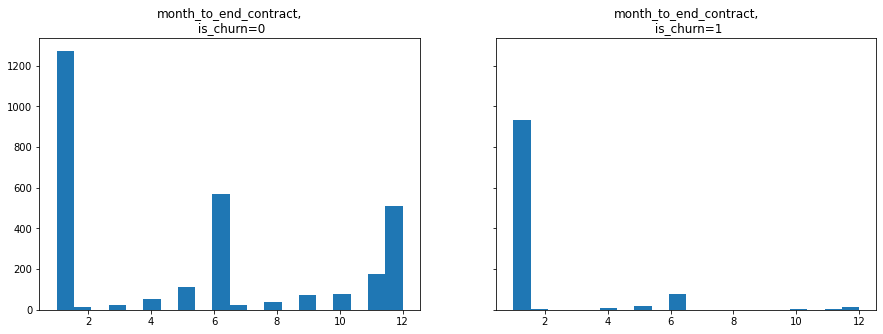

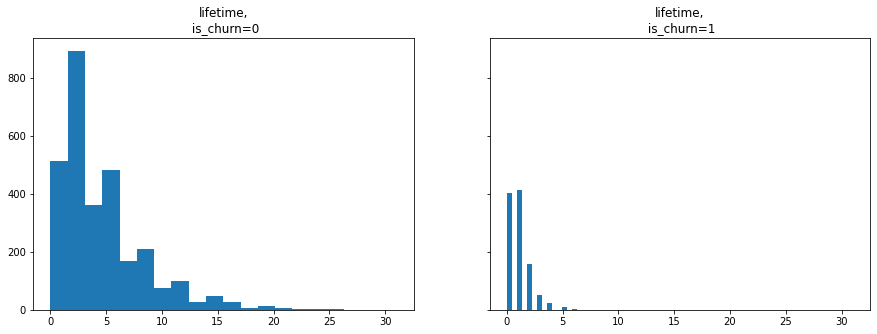

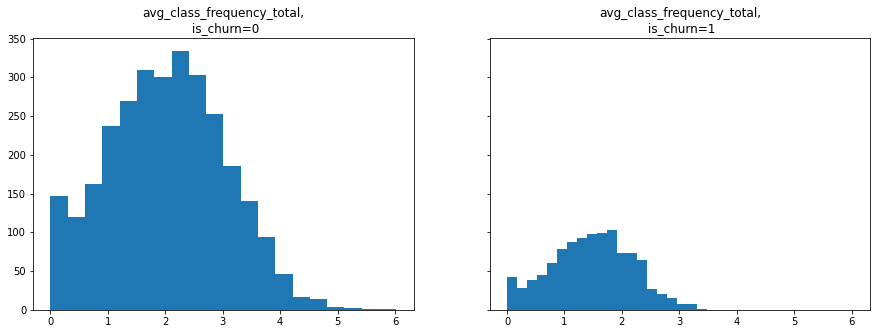

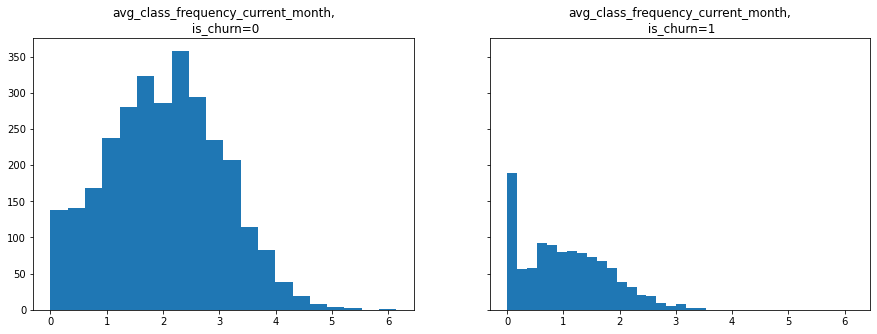

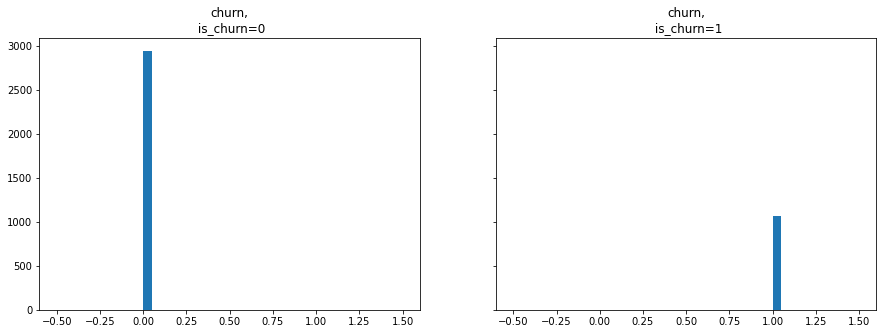

In [10]:
# напишем функцию, которая будет принимать 
# 1) признак (название колонки датафрейма), 
# 2) номер колонки в сетке диаграмм для признака (0 или 1) 
# 3) номер строки в сетке диаграмм для признака (0),
# 4) значение целевой переменной (0 или 1),
# а возвращать 2 гистограммы распределения признака

def create_hist(col, x, y, is_churn):
    gym[gym['churn'] == is_churn][col].hist(grid=False, ax=ax[x], bins=20)\
                                    .set(title=col + f',\n is_churn={is_churn}');

# теперь применим функцию ко всем признакам
for col in gym.columns.to_list():
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharex=True, sharey=True)
    create_hist(col, 0, 0, 0)
    create_hist(col, 1, 0, 1)
    plt.show()

В дополнение к характеристикам небинарных признаков можно отметить следующее:
- Среди оставшихся абонементы на год более популярны, чем абонементы на 6 месяцев. А среди ушедших - наоборот. Т.е. если человек купил абонемент на год, то он, вероятнее всего, останется.
- Возраст основной массы оставшихся - от 25 до 35 и выражен пик в районе 31 года, а возраст основной массы ушедших - от 23 до 32 и таких явных пиков нет. Т.е. аудитория, склонная к оттоку чуть моложе постоянных клиентов и более равномерно распределена по возрасту.
- Клиенты, которые потратили на сопутствующие товары и услуги более 300 у.е., скорее всего, останутся.
- Склонные к оттоку посетители занимаются в клубе не более полугода.
- Наиболее склонны к оттоку клиенты, занимающиеся не более 2х раз в неделю.



### Матрица корреляций

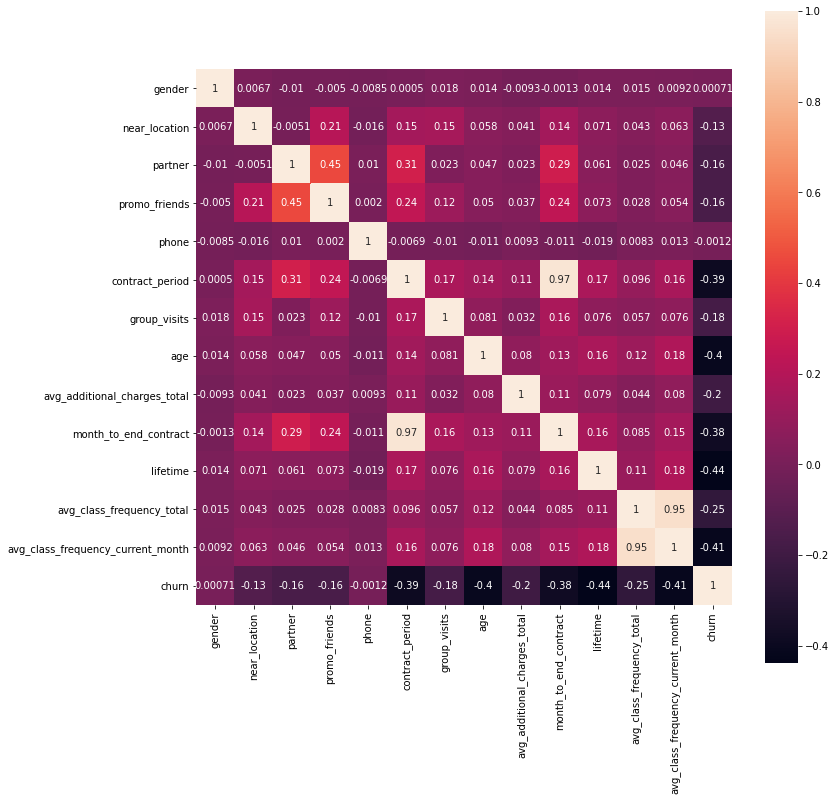

In [11]:
plt.figure(figsize=(12,12))
sns.heatmap(gym.corr(), annot=True, square=True)
plt.show()

Наибольшее влияние на отток оказывают следующие признаки:
- срок, прошедший с момента первого обращения (-0,44),
- частота посещений за последний месяц (-0,41),
- возраст (-0,4),
- срок абонемента (-0,39),
- срок до окончания абонемента(-0,38).

Матрица корреляции подтверждает, что пол и наличие контактного телефона в базе практически не влияют на отток, можем их удалять. 

Также у нас есть сильно коррелирующие между собой пары признаков:
 - срок абонемента и количество месяцев до окончания абонемента (для прогноза оттока в следующем месяце оставим второй);
 - средняя посещаемость за весь период и за последний месяц (для прогноза оттока в следующем месяце логичнее использовать второй).
 
Удалим лишние признаки:

In [12]:
gym = gym.drop(['gender', 'phone', 'contract_period', 'avg_class_frequency_total'], axis=1)
gym.sample(3)

,near_location,partner,promo_friends,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_current_month,churn
3346,1,0,1,0,24,35.664125,1.0,0,1.011329,1
595,0,1,0,0,30,55.177486,1.0,5,3.943236,0
2150,0,1,0,1,30,168.618696,1.0,1,1.272483,1


### Вывод

Мы удалили пол и наличие контактного телефона в базе денных, т.к. данные признаки не влияют на отток.


Также мы избавились от мультиколинеарности, удалив срок действия абонемента и среднюю посещаемость за весь период.

В итоге осталось 9 признаков, среди которых наибольшее влияние на отток оказывают:
- срок, прошедший с момента первого обращения,
- частота посещений за последний месяц,
- возраст,
- срок до окончания абонемента.

Портрет наиболее склонного к оттоку клиента (чем больше признаков присутствует одновременно, тем больше вероятность ухода):
- живет и работает далеко от клуба;
- не является сотрудником компании-партнера;
- не пользовался промо-кодом друга;
- не посещает групповые занятия;
- возраст до 32 лет;
- потратил менее 300 у.е. на сопутствующие товары и услуги;
- абонемент заканчивается через месяц;
- пришел впервые в клуб менее полугода назад;
- посещает занятия не чаще 2х раз в неделю.


## Модель прогнозирования оттока клиентов

### Функция для обучения модели и расчета метрик

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце. 

Для этого разобьем данные на обучающую и валидационную выборку:

In [13]:
X = gym.drop('churn', axis=1)
y = gym['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Обучим модель  на train-выборке двумя способами: логистической риегрессией и случайным лесом. Чтобы не дублировать код, напишем функцию, которая будет принимать название модели и возвращать долю правильных ответов, точность, полноту, f1-меру и площадь под кривой ошибок:

In [14]:
def model_train(mod):
    model = mod
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    probabilities = model.predict_proba(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score (y_test, y_pred)
    recall = recall_score (y_test, y_pred)
    f1= f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, probabilities[:,1])
    
    print('Для модели {}:\n доля правильных ответов = {:.2f} \n точность = {:.2f} \
    \n полнота = {:.2f} \n F1-мера = {:.2f} \n площадь под кривой ошибок = {:.2f}'\
          .format(mod, acc, precision, recall, f1, roc_auc))

### Сравнение моделей

Применим нашу функцию сначала для логистистической регрессии:

In [15]:
model_train(LogisticRegression(solver='liblinear', random_state=0))

Для модели LogisticRegression(random_state=0, solver='liblinear'):
 доля правильных ответов = 0.90 
 точность = 0.79     
 полнота = 0.79 
 F1-мера = 0.79 
 площадь под кривой ошибок = 0.96


А теперь сделаем то же самое для случайного леса:

In [16]:
model_train(RandomForestClassifier(n_estimators = 100, random_state=0))

Для модели RandomForestClassifier(random_state=0):
 доля правильных ответов = 0.90 
 точность = 0.81     
 полнота = 0.77 
 F1-мера = 0.79 
 площадь под кривой ошибок = 0.95


### Вывод

Доля правильных ответов у расматриваемых моделей одинакова - 0,9.

Точность (доля правильных ответов среди целевого класса, т.е. оттока) выше у случайного леса (0,81 против 0,79). Т.е модель случайного леса минимизирует ложноположительные результаты.

Полнота (сколько реальных объектов целевого класса обнаружено) выше у логистической регрессии (0,79 против 0,77). Данная модель минимизирует ложноотрицательные результаты. Нам ложноотрицательные результаты "страшнее" (лучше провести лишние профилактические противооттоковые мероприятия для клиента, чем упустить его).

F1-мера у обеих моделей составляет 0,79.

Площадь под кривой ошибок ближе к 1 у линейной регрессии (0,96 против 0,95).

Итак, в нашем случае линейная регрессия даст более точный прогноз.

## Кластеризация клиентов

### Стандартизация признаков

Чтобы разбить клиентов на кластеры, проведем сначала стандартизацию признаков.

In [17]:
scaler = StandardScaler()
x_sc = scaler.fit_transform(X)

### Матрица расстояний и дендрограмма

Теперь построим матрицу расстояний и дендрограмму:

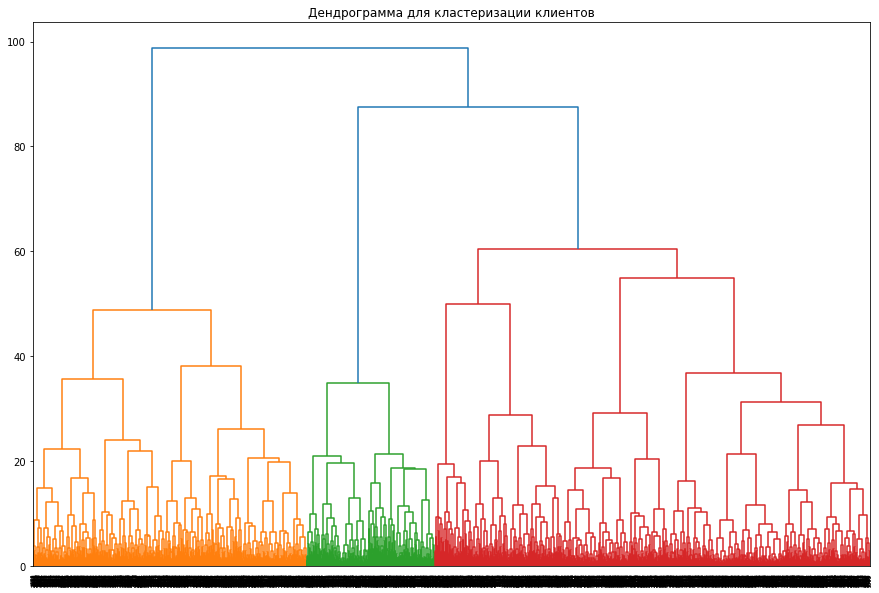

In [18]:
linked = linkage(x_sc, method = 'ward')

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендрограмма для кластеризации клиентов')
plt.show()

Судя по количеству цветов на дендрограмме, оптимальное количество кластеров - 3. Но тогда кластер 3 получается слишком большой, чтобы наш подход был более гибким и индивидуальным, разобьем клиентов на 4 группы.

### Прогнозирование кластеров клиентов

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. 

In [19]:
km = KMeans(n_clusters=4, random_state=0) 
labels = km.fit_predict(x_sc)

Теперь добавим номера кластеров в наш датасет и сгруппируем его по номеру кластера, чтобы посмотреть на средние значения признаков для каждой группы клиентов:

In [20]:
labels = list(labels)
gym['cluster_km'] = labels

clasters = gym.groupby('cluster_km').agg('mean')
clasters.T

cluster_km,0,1,2,3
near_location,1.000000,0.996350,0.000000,0.996429
partner,0.219949,0.884124,0.489362,0.375893
promo_friends,0.068201,1.000000,0.075286,0.010714
group_visits,0.283887,0.525547,0.230769,0.534821
age,27.589088,29.642336,28.680851,30.681250
avg_additional_charges_total,117.552268,154.056489,137.210096,176.075732
month_to_end_contract,1.925831,6.308394,2.828151,5.705357
lifetime,1.867008,4.264599,2.993453,5.541071
avg_class_frequency_current_month,1.212463,1.913861,1.596004,2.297535
churn,0.568627,0.117701,0.402619,0.016964


Интересно также посмотреть на численность кластеров:

In [21]:
clasters_size = gym.groupby('cluster_km')['age'].agg('count').reset_index()
clasters_size.columns = ['cluster_km', 'size']
clasters_size['share'] = clasters_size['size'] / clasters_size['size'].sum()
clasters_size = clasters_size.style.format({'share':'{:.1%}'})
clasters_size

,cluster_km,size,share
0,0,1173,29.3%
1,1,1096,27.4%
2,2,611,15.3%
3,3,1120,28.0%


Кластер 2 самый малочисленный, остальные примерно одинаковы по размеру.
Кластеры 0 и 2 склонны к оттоку, кластеры 1 и 3 достаточно лояльны.

### Распределение признаков по кластерам

Визуализируем распределение признаков по кластерам для большей наглядности. Для этого напишем функцию, которая будет принимать, датафрейм, признак группировки и список параметров для сравнения:

Распределение признака near_location по кластерам


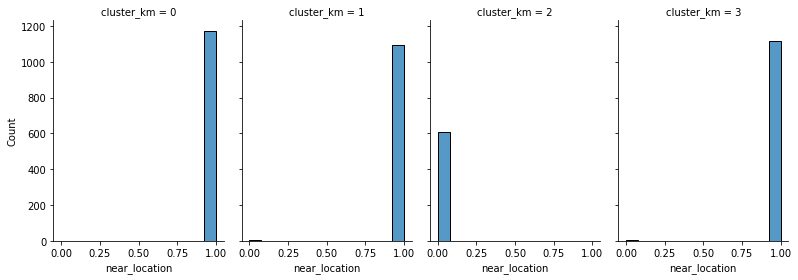

Распределение признака partner по кластерам


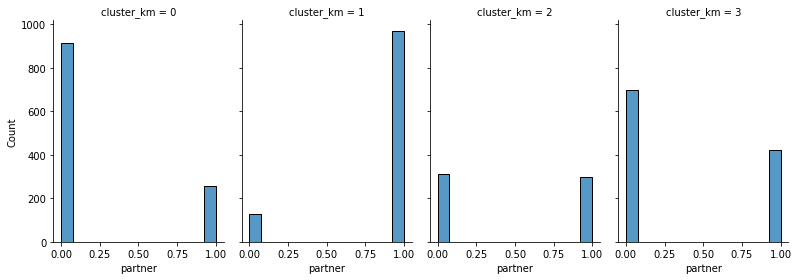

Распределение признака promo_friends по кластерам


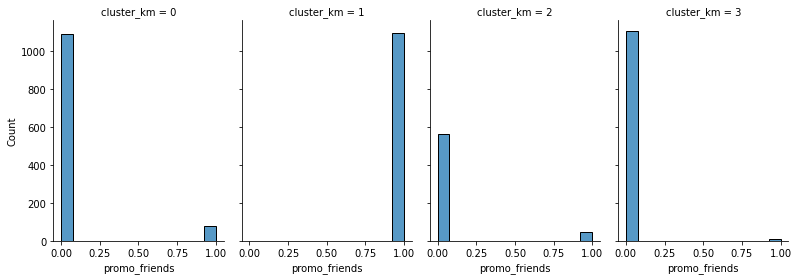

Распределение признака group_visits по кластерам


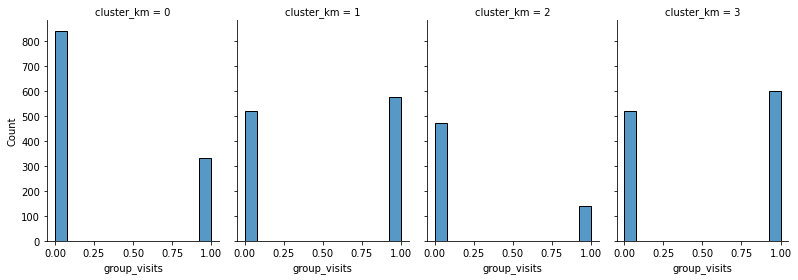

Распределение признака age по кластерам


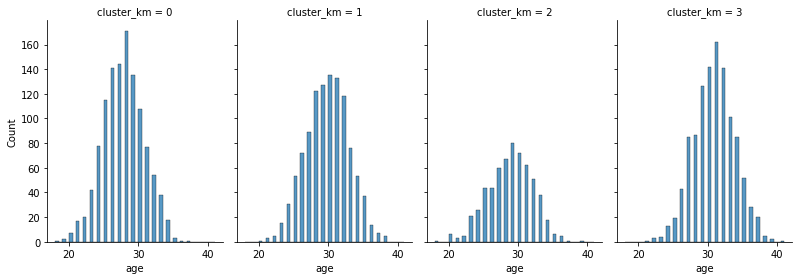

Распределение признака avg_additional_charges_total по кластерам


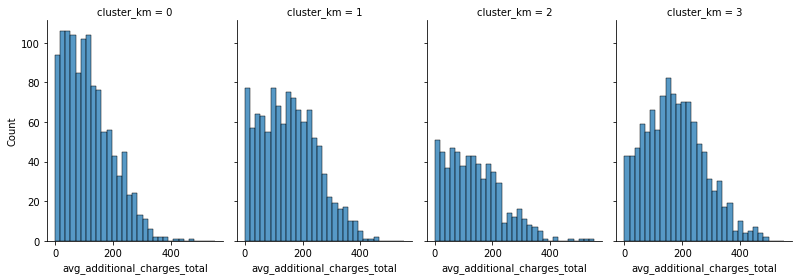

Распределение признака month_to_end_contract по кластерам


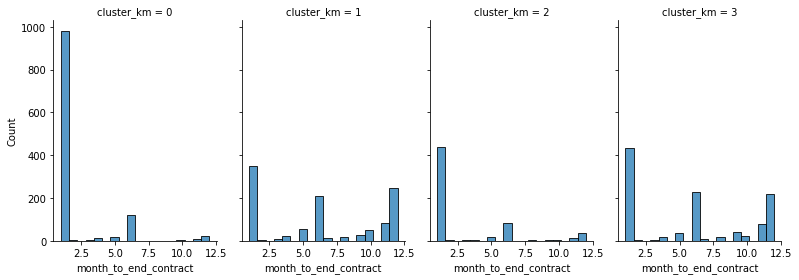

Распределение признака lifetime по кластерам


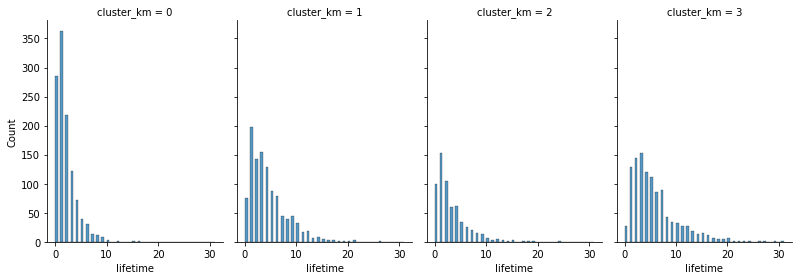

Распределение признака avg_class_frequency_current_month по кластерам


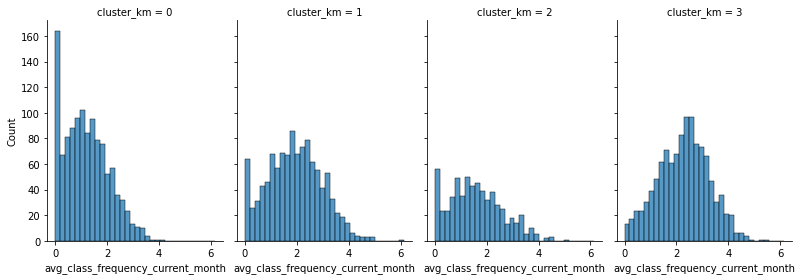

Распределение признака churn по кластерам


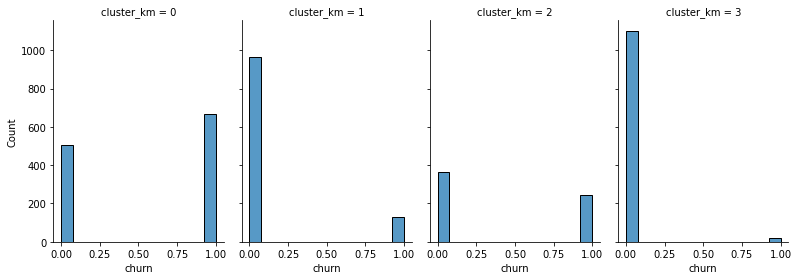

Распределение признака cluster_km по кластерам


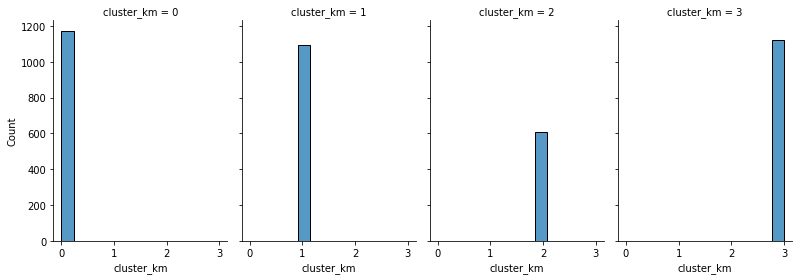

In [22]:
def compare(df, group, features):
    df_new = gym.copy()
    df_new[features] = df[features]
    for f in features:
        print('Распределение признака {} по кластерам'.format(f))
        sns.displot(data=df_new, x=df_new[f], col=group,
                    height=4, aspect=0.7)
        plt.show()
        
compare(gym, 'cluster_km', gym.columns)

### Вывод

**Кластер 0 - наиболее склонные к оттоку (в 57% случаев)**:
- живут или работают рядом
- реже других являются сотрудниками компаний-партнеров
- предпочитают индивидуальные и самостоятельные тренировки
- средний возраст 28 лет
- потратили на сопутствующие товары меньше всех - в среднем 118 у.е., в основной своей массе - до 180 у.е.
- до окончания абонемента осталось менее 2х месяцев
- занимаются в клубе менее 2х месяцев, посещают тренировки от 0 до 2х раз в неделю, в среднем 1 раз в неделю


Назовем их условно "Новички", т.к. они недавно пришли в клуб. Они присматриваются, пока еще не привыкли и не втянулись, возможно, чувствуют себя в клубе неуверенно, т.к. не обзавелись знакомствами, не выбрали себе оптимальный вид нагрузки.

**Кластер 1 - малосклонные к оттоку (в 12% случаев)**:
- живут или работают рядом
- часто являются сотрудниками компаний-партнеров
- воспользовались промокодом друга
- посещают как групповые, так и индивидуальные/самостоятельные занятия
- средний возраст 30 лет
- потратили дополнительно к абонементам в среднем 154 у.е., в основной массе  - до 250 у.е.
- до окончания абонемента осталось в среднем более 6 месяцев
- в клубе уже более 4х месяцев, тренируются от 0 до 3 х раз св неделю, в среднем 2 раза в неделю


Назовем их условно "Пришедшие за компанию", т.к. они воспользовались промокодом друга. Пример друзей/коллег служит для них дополнительной мотивацией продолжать занятия.

**Кластер 2 - средне склонные к оттоку (в 40% случаев)**:
- живут и работают далеко от клуба
- могут как являться сотрудниками компаний-партнеров, так и не являться (50/50)
- предпочитают индивидуальные и самостоятельные тренировки
- средний возраст 29 лет
- потратили дополнительно в среднем 137 у.е., в основной массе - до 220 у.е.
- до окончания абонемента осталось большей частью менее 2х месяцев
- занимаются в клубе 3 месяца, от 0 до 2х раз в неделю, в среднем 1,5 реза в неделю


Назовем их условно "Самомотивированные", т.к. чтобы добираться в фитнес-клуб издалека однозначно требуется самомотивация. Их склонность к оттоку, скорее всего, как раз и вызвана неудобством логистики.

**Кластер 3 - не склонные к оттоку (попадают в отток только в 2% случаев)**:
- живут или работают рядом
- могут как являться сотрудниками компаний-партнеров, так и не являться, но чаще не являются
- средний возраст - 31 год
- больше всех потратили денег на дополнительные "плюшки" - 176 у.е., в основной массе - до 300 у.е.
- до окончания абонемента осталось в среднем более 5 месяцев
- занимаются в клубе более 5 месяцев от 1 до 4х раз в неделю, в среднем чаще 2х раз в неделю.


Назовем их условно "Лояльные". Им все удобно и привычно. Это самая взрослая и стабильная аудитория.

## Выводы и рекомендации

Исследованы данные по 4 000 клиентов сети фитнес-клубов. Среди 13 характеристик клиентов  выделены 9, влияющих на отток.

Наибольшее влияние на отток оказывают следующие признаки:

- срок, прошедший с момента первого обращения,
- частота посещений за последний месяц,
- возраст,
- срок до окончания абонемента.

Для прогнозирования оттока клиентов были обучены 2 модели - логистическая регрессия и случайный лес, рассчитаны метрики:
- доля правильных ответов, 
- точность, 
- полнота, 
- f1-мера,
- площадь под кривой ошибок. 


Сравнительный анализ метрик показал, что модель логистической регрессии является более предпочтительной для прогнозирования оттока, т.к. она минимизирует ложноотрицательные результаты и помогает "перестраховаться".

Проведена кластеризация клиентов, всего выделено 4 кластера:
- "Новички" (кластер 0)
- "Самомотивированные" (кластер 2)
- "Пришедшие за компанию" (кластер 1)
- "Лояльные" (кластер 3)

**Описание кластеров и рекомендации по работе с ними**:

**"Новички"** - склонны к оттоку в 57% случаев. Редко являются сотрудниками компаний-партнеров, редко посещают групповые занятия, занимаются в клубе в среднем менее 2х месяцев, посещают тренировки в среднем 1 раз в неделю, до окночания абонемента осталось менее 2х месяцев, потратили на сопутствующие товары и услуги до 180 у.е., средний возраст 28 лет. При этом живут либо работают рядом. Главная проблема - слабая вовлеченность.

С данной группой рекомендуется работать по профилактике оттока наиболее активно. Важно социализировать их, чтобы почувствовали себя в клубе своими - вовлекать в групповые тренировки ("для разнообразия" и заведения новых друзей), знакомить с направлениями и инструкторами, помогать выбрать оптимальный уровень нагрузки и режим занятий, чтобы "подсадить" на регулярные тренировки хотя бы 2 раза в неделю, предлагать дополнительные товары и услуги, но без навязывания. 

**"Самомотивированные"** - склонны к оттоку в 40% случаев. Самый малочисленный кластер, в 2 раза меньше остальных. Их главная проблема - далеко живут/работают, т.е. неудобная логистика. Отсюда и редкая посещаемость - 1,5 раза в неделю, и склонность бросать занятия, когда самомотивация заканчивается. Средний возраст 29 лет. Для них, возможно, стоит разработать систему индивидуальных бонусов/скидок/промокодов, желательно, накопительных, чтобы они были заинтересованы дольше оставаться в клубе и больше тратить там денег. Но слишком цепляться за этот кластер не стоит, все-таки если человеку долго/неудобно добираться до клуба, то скорее всего, он уйдет, даже несмотря на выгодные предложения. 

**"Пришедшие за компанию"** - стабильный кластер, склонен к оттоку только в 12% случаев. Их отличительная черта - пришли по акции "Приведи друга", и часто являются сотрудниками компаний-партнеров, соответственно в клубе у них уже есть знакомства и положительный пример друга/коллег. Средний возраст 30 лет. Данный кластер в профилактике оттока практически не нуждается. Можно расширять перечень компаний-партнеров (рассчитав рентабельность такого партнерства, разумеется). Сотрудники компаний-партнеров склонны посещать занятия регулярно, длительно и приобретать дополнительные товары и услуги. Если этот кластер станет самым массовым, он может и не принесет сверхприбылей, но обеспечит устойчивость бизнесу.

**Лояльные** - самый стабильный кластер, склонен к оттоку только в 2% случаев. Их все устраивает, занимаются более 5 месяцев и более 2х раз в неделю, охотно тратят деньги на дополнительные товары и услуги. Средний возраст - 31 год. Специальных мероприятий по профилактике оттока не требует. Чтобы расширять данный кластер, стоит больше ориентироваться в рекламно-информационных кампаниях на целевую аудиторию в возрасте 30-35 лет, т.к. более молодая аудитория менее постоянна.